## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI2D-axial' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
horizontal_wavelet_axial_syntheticMRI2D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI2D/axial/wavelet/horizontal'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4,
 3: 20050,
 4: 180942,
 5: 922650,
 6: 4185552,
 7: 17688454,
 8: 72685058,
 9: 295085108}

Running 12760 CDFs


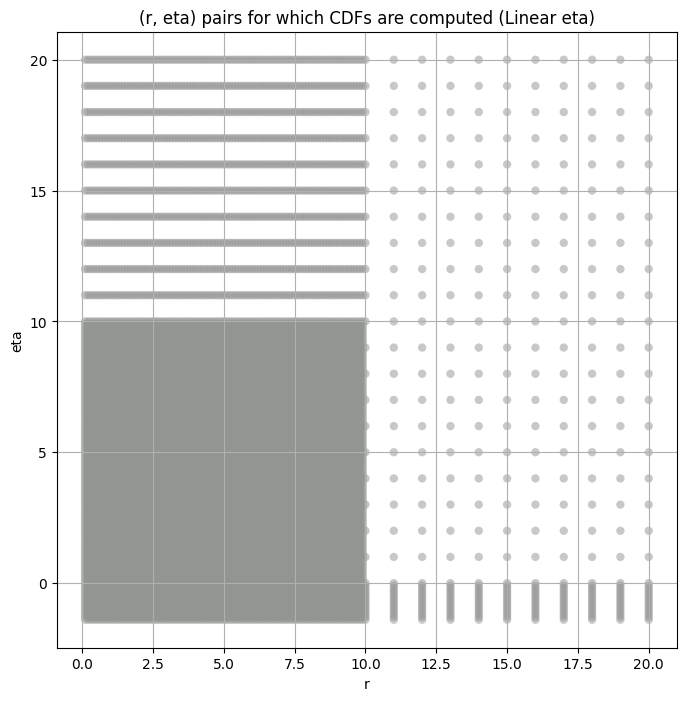

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:48<00:00, 2063.21it/s]


Layer 3


100%|██████████| 100000/100000 [01:17<00:00, 1288.49it/s]


Layer 4


100%|██████████| 100000/100000 [01:08<00:00, 1458.86it/s]


Layer 5


100%|██████████| 100000/100000 [01:12<00:00, 1385.79it/s]


Layer 6


100%|██████████| 100000/100000 [01:19<00:00, 1259.53it/s]


Layer 7


100%|██████████| 100000/100000 [01:06<00:00, 1508.92it/s]


Layer 8


100%|██████████| 100000/100000 [01:09<00:00, 1436.76it/s]


Layer 9


100%|██████████| 100000/100000 [01:09<00:00, 1437.97it/s]


obs_var      var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                     
2      141841.72000       0.000000  209572.11000  -1.771987         NaN   
3      736460.30000  720182.060000  752624.20000  -1.273356   -1.336073   
4      465219.00000  445174.600000  485257.53000   0.832306    0.714066   
5      108838.26600  102539.490000  115350.62500   3.238030    2.715251   
6       47219.99000   43794.440000   50741.45700   6.126480    5.564133   
7        9147.18800    8511.764000    9801.52700   5.519940    5.009598   
8         918.93930     848.773740     993.63250   7.176670    5.902757   
9          78.41065      70.487915      87.48717  15.212063   10.426363   

       kurt_upper  total_samples  
layer                             
2             NaN            4.0  
3       -1.193367        20050.0  
4        0.962902       180942.0  
5        3.809224       922650.0  
6        6.721452      4185552.0  
7        6.143659     17688454.0  
8       11.482376     72685058.0  
9       33.707012    295085108.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      141841.72000  141841.718750             NaN             NaN   
3      736460.30000  736460.312500   726554.000000   721626.562500   
4      465219.00000  465219.000000   462606.781250   460468.906250   
5      108838.26600  108838.265625   107210.132812   105890.085938   
6       47219.99000   47219.988281    46514.066406    45902.210938   
7        9147.18800    9147.188477     9018.613281     8912.190430   
8         918.93930     918.939270      898.369263      884.531189   
9          78.41065      78.410652       75.089447       73.141388   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       717118.500000    712830.500000    704782.562500    697304.000000   
4       458415.500000    456417.312500    452553.812500    448816.375000   
5       104694.109375    103582.484375    101562.828125     99742.312500   
6        45330.699219     44785.761719     43756.726562     42793.031250   
7         8813.709961      8720.506836      8545.312500      8381.149414   
8          872.128052       860.623779       839.507263       820.206970   
9           71.450111        69.922974        67.211212        64.830925   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3        690156.062500    683272.500000    676626.437500    657579.562500  
4        445176.750000    441608.750000    438106.062500    427917.968750  
5         98088.046875     96583.937500     95198.164062     91559.046875  
6         41882.503906     41016.187500     40187.281250     37888.714844  
7          8225.534180      8076.993164      7934.412598      7535.930176  
8           802.258911       785.389954       769.420959       725.857483  
9            62.696312        60.756565        58.977089        54.377712

####
Layer  2


100%|██████████| 12760/12760 [00:01<00:00, 10129.46it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.2659183720558835 141841.72


100%|██████████| 12760/12760 [00:00<00:00, 14951.41it/s]


Finding Minimum after computing 12760 CDFs
2 25 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 16640.18it/s]


Finding Minimum after computing 12760 CDFs
2 50 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 16708.88it/s]


Finding Minimum after computing 12760 CDFs
2 75 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 17412.92it/s]


Finding Minimum after computing 12760 CDFs
2 100 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 15991.86it/s]


Finding Minimum after computing 12760 CDFs
2 150 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 15601.62it/s]


Finding Minimum after computing 12760 CDFs
2 200 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 15852.78it/s]


Finding Minimum after computing 12760 CDFs
2 250 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 16749.02it/s]


Finding Minimum after computing 12760 CDFs
2 300 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 15780.03it/s]


Finding Minimum after computing 12760 CDFs
2 350 nan nan


100%|██████████| 12760/12760 [00:00<00:00, 17056.72it/s]


Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 4, Without approximation : 4.0


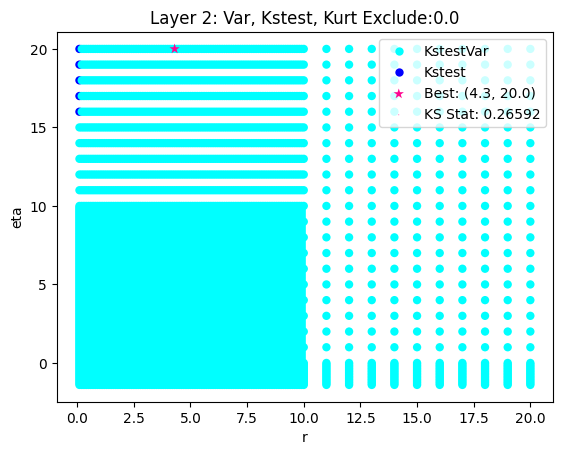

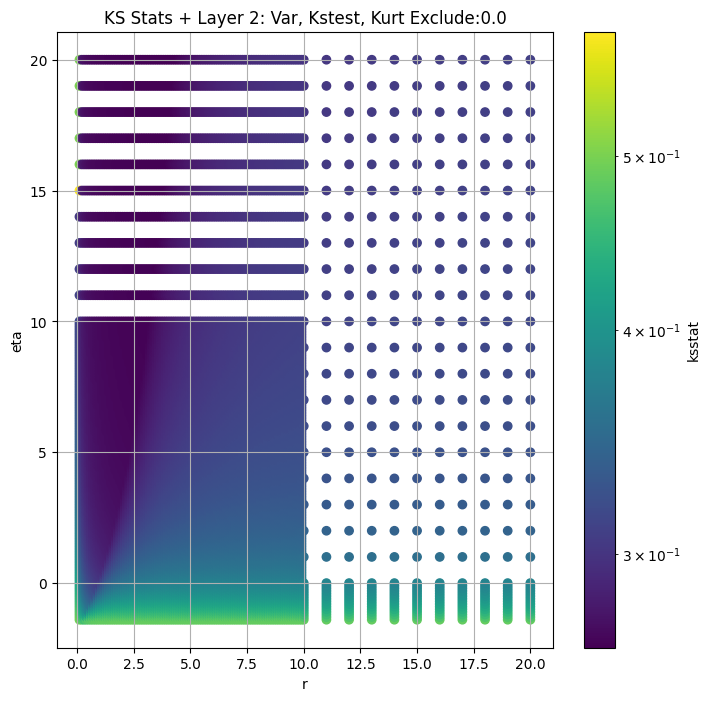

####
Layer  3


100%|██████████| 12760/12760 [00:11<00:00, 1066.31it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.08873989755032402 736460.3


100%|██████████| 12760/12760 [00:12<00:00, 1058.84it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.0900456979462898 726554.0


100%|██████████| 12760/12760 [00:11<00:00, 1065.81it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.0907040754264068 721626.56


100%|██████████| 12760/12760 [00:11<00:00, 1072.30it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.09131168070246531 717118.5


100%|██████████| 12760/12760 [00:13<00:00, 955.30it/s] 


Finding Minimum after computing 12760 CDFs
3 100 0.09189435766797449 712830.5


100%|██████████| 12760/12760 [00:12<00:00, 1060.28it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.09300062900804684 704782.56


100%|██████████| 12760/12760 [00:11<00:00, 1071.63it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.09388006411356514 697304.0


100%|██████████| 12760/12760 [00:11<00:00, 1071.70it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.09489071308043912 690156.06


100%|██████████| 12760/12760 [00:11<00:00, 1070.94it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.0958771658292093 683272.5


100%|██████████| 12760/12760 [00:12<00:00, 1035.08it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.09685458559738358 676626.44


100%|██████████| 12760/12760 [00:12<00:00, 1050.83it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.09982441879221854 657579.56
Number of samples: 20050, Without approximation : 20050.0


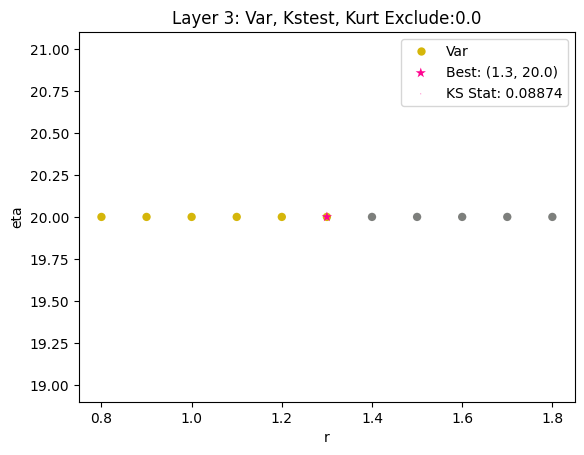

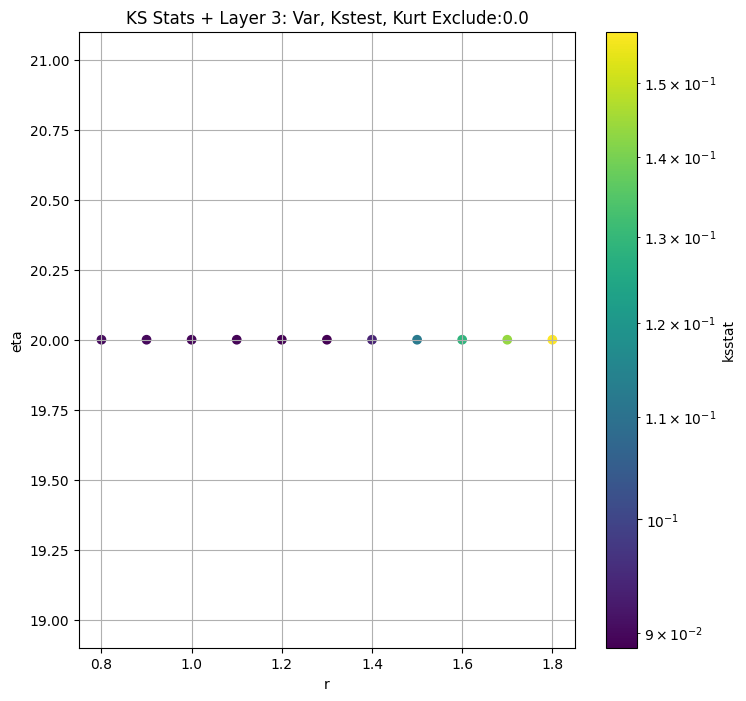

####
Layer  4


100%|██████████| 12760/12760 [00:57<00:00, 223.28it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.014597696685821782 465219.0


100%|██████████| 12760/12760 [00:59<00:00, 215.66it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.014597696685821782 462606.78


100%|██████████| 12760/12760 [00:58<00:00, 217.91it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.014597696685821782 460468.9


100%|██████████| 12760/12760 [00:58<00:00, 218.87it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.014597696685821782 458415.5


100%|██████████| 12760/12760 [00:57<00:00, 221.47it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.014597696685821782 456417.3


100%|██████████| 12760/12760 [00:59<00:00, 214.18it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.014597696685821782 452553.8


100%|██████████| 12760/12760 [00:58<00:00, 216.79it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.014294697960790553 448816.38


100%|██████████| 12760/12760 [00:57<00:00, 221.05it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.013892614480876864 445176.75


100%|██████████| 12760/12760 [00:57<00:00, 221.20it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.01415017319435563 441608.75


100%|██████████| 12760/12760 [00:59<00:00, 214.31it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.014486700088388482 438106.06


100%|██████████| 12760/12760 [00:58<00:00, 219.89it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.015497316044151874 427917.97
Number of samples: 100000, Without approximation : 180942.0


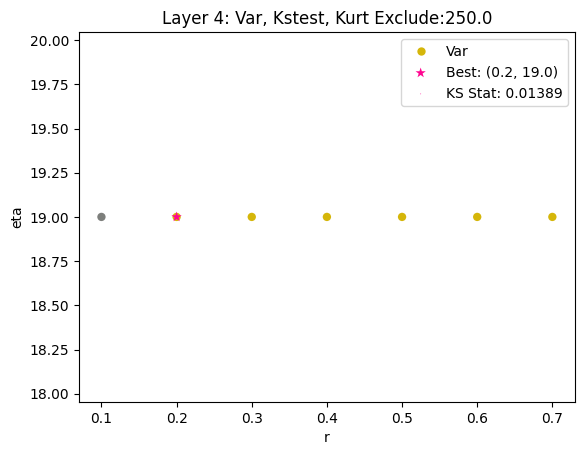

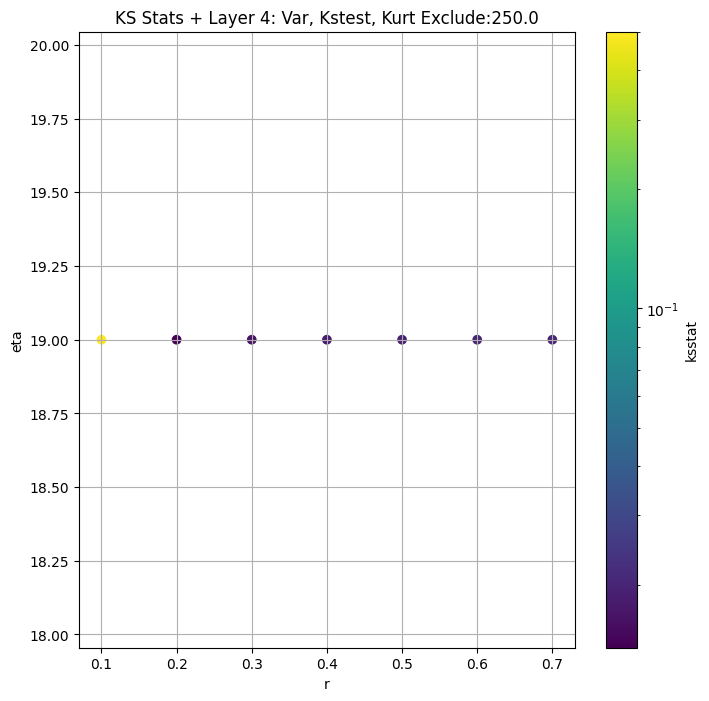

####
Layer  5


100%|██████████| 12760/12760 [01:04<00:00, 199.32it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.004707543773230294 108838.266


100%|██████████| 12760/12760 [00:58<00:00, 219.00it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.004722091425348962 107210.13


100%|██████████| 12760/12760 [00:57<00:00, 223.06it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.0042308749518897015 105890.086


100%|██████████| 12760/12760 [00:59<00:00, 214.96it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.004438365771003094 104694.11


100%|██████████| 12760/12760 [00:57<00:00, 221.35it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.004787344490600583 103582.484


100%|██████████| 12760/12760 [00:57<00:00, 221.83it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.00552336689091662 101562.83


100%|██████████| 12760/12760 [00:58<00:00, 217.10it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.0062195274274117265 99742.31


100%|██████████| 12760/12760 [01:04<00:00, 196.45it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.0067493612484307505 98088.05


100%|██████████| 12760/12760 [00:59<00:00, 214.97it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.007245261380034167 96583.94


100%|██████████| 12760/12760 [00:58<00:00, 217.62it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.007832611554735802 95198.164


100%|██████████| 12760/12760 [00:59<00:00, 215.20it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.009340040726063724 91559.05
Number of samples: 100000, Without approximation : 922650.0


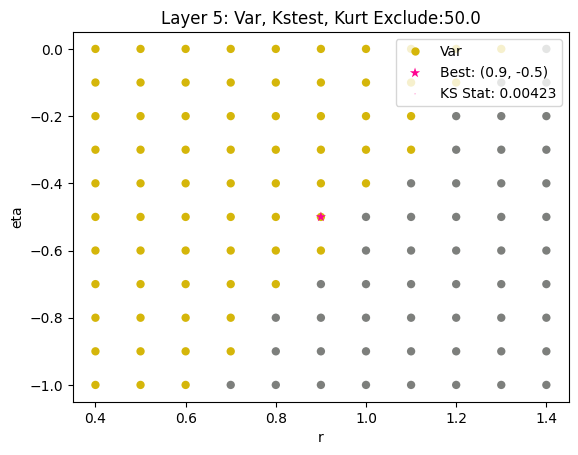

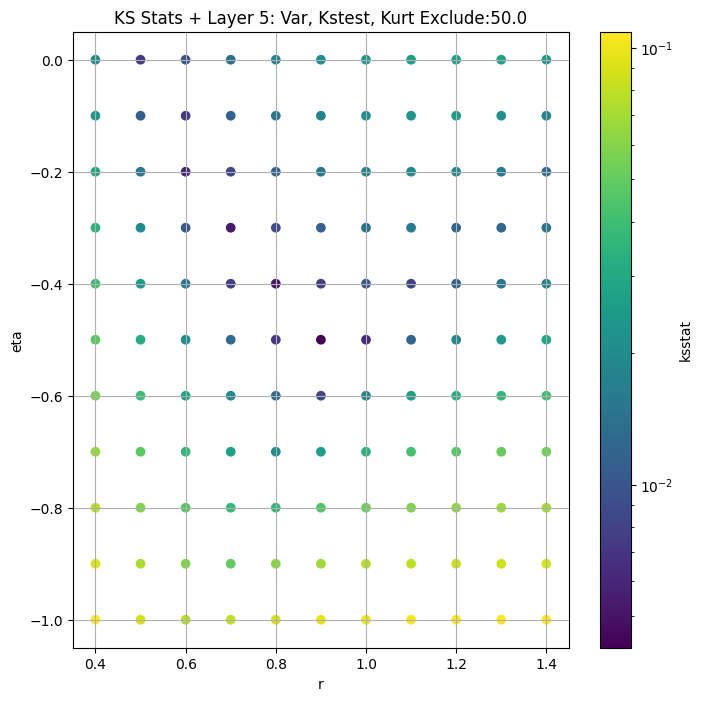

####
Layer  6


100%|██████████| 12760/12760 [01:00<00:00, 210.21it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.010350859968532744 47219.99


100%|██████████| 12760/12760 [00:57<00:00, 221.02it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.009868695104516434 46514.066


100%|██████████| 12760/12760 [00:58<00:00, 216.85it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.00944274203010087 45902.21


100%|██████████| 12760/12760 [00:58<00:00, 217.82it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.009037916716809258 45330.7


100%|██████████| 12760/12760 [01:01<00:00, 208.10it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.008730331871014574 44785.76


100%|██████████| 12760/12760 [00:57<00:00, 221.31it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.01034429401132797 43756.727


100%|██████████| 12760/12760 [00:59<00:00, 215.22it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.010278057992502365 42793.03


100%|██████████| 12760/12760 [00:57<00:00, 220.59it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.009304325210866438 41882.504


100%|██████████| 12760/12760 [01:04<00:00, 198.99it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.008582515459089168 41016.188


100%|██████████| 12760/12760 [00:57<00:00, 222.47it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.008055588707824241 40187.28


100%|██████████| 12760/12760 [00:58<00:00, 216.55it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.009295901609019497 37888.715
Number of samples: 100000, Without approximation : 4185552.0


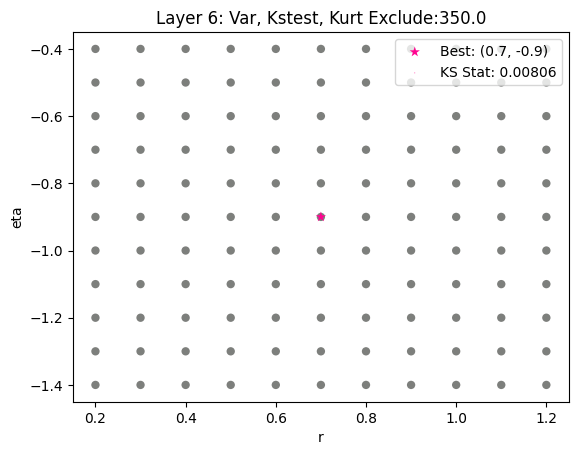

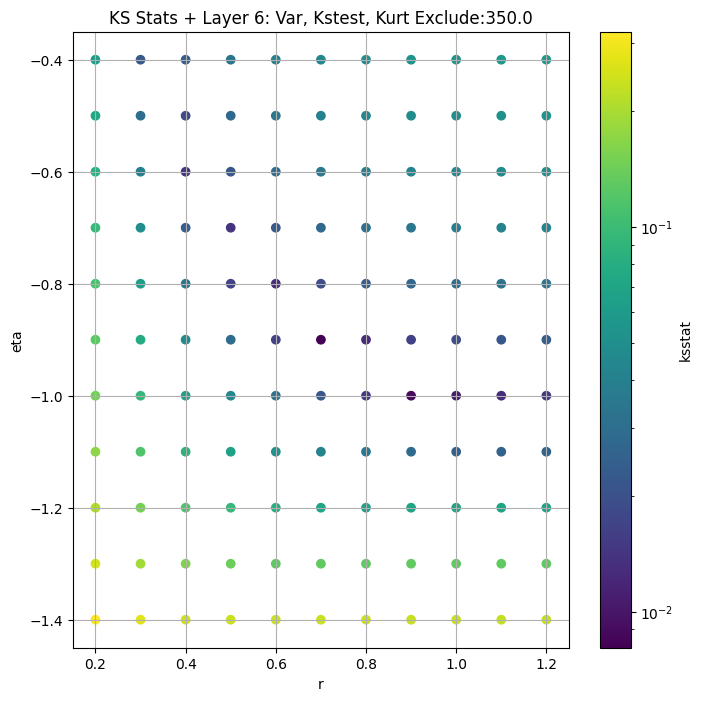

####
Layer  7


100%|██████████| 12760/12760 [00:57<00:00, 221.63it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.01076757078885815 9147.188


100%|██████████| 12760/12760 [00:57<00:00, 222.83it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.009893019051075244 9018.613


100%|██████████| 12760/12760 [00:57<00:00, 220.08it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.009161826720557209 8912.19


100%|██████████| 12760/12760 [00:57<00:00, 222.83it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.009283083314956215 8813.71


100%|██████████| 12760/12760 [00:57<00:00, 223.38it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.009613425755462472 8720.507


100%|██████████| 12760/12760 [00:57<00:00, 223.19it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.010248152233654127 8545.3125


100%|██████████| 12760/12760 [00:58<00:00, 219.59it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.010861633023828483 8381.149


100%|██████████| 12760/12760 [00:57<00:00, 220.09it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.011449460922308904 8225.534


100%|██████████| 12760/12760 [00:58<00:00, 217.84it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.01135969772612504 8076.993


100%|██████████| 12760/12760 [01:01<00:00, 207.19it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.01191627667808589 7934.4126


100%|██████████| 12760/12760 [00:58<00:00, 216.30it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.013127520856456305 7535.93
Number of samples: 100000, Without approximation : 17688454.0


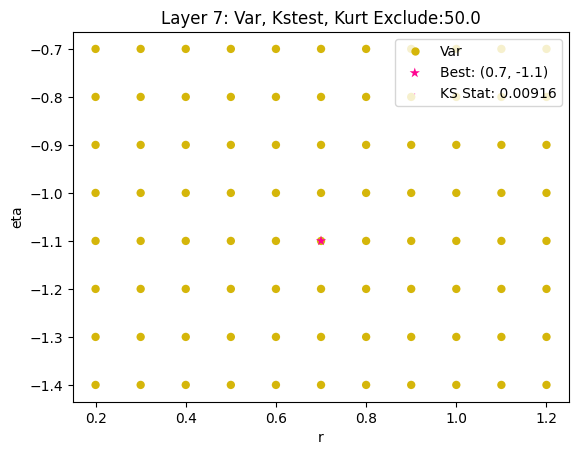

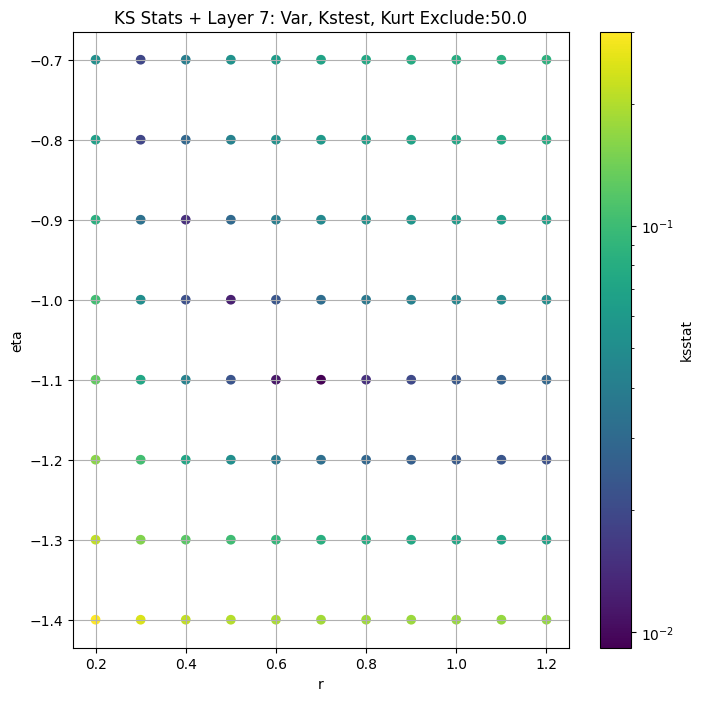

####
Layer  8


100%|██████████| 12760/12760 [01:34<00:00, 134.97it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.010453889387836646 918.9393


100%|██████████| 12760/12760 [00:56<00:00, 225.32it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.00945367916766976 898.36926


100%|██████████| 12760/12760 [00:57<00:00, 220.94it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.0097832310390559 884.5312


100%|██████████| 12760/12760 [00:58<00:00, 218.92it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.010282168939587444 872.12805


100%|██████████| 12760/12760 [02:37<00:00, 81.23it/s] 


Finding Minimum after computing 12760 CDFs
8 100 0.010755384414454117 860.6238


100%|██████████| 12760/12760 [02:07<00:00, 99.75it/s] 


Finding Minimum after computing 12760 CDFs
8 150 0.011638221402602622 839.50726


100%|██████████| 12760/12760 [01:33<00:00, 135.92it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.01245766858726275 820.207


100%|██████████| 12760/12760 [16:45<00:00, 12.68it/s]  


Finding Minimum after computing 12760 CDFs
8 250 0.01323899330684418 802.2589


100%|██████████| 12760/12760 [2:35:20<00:00,  1.37it/s]   


Finding Minimum after computing 12760 CDFs
8 300 0.012467390312265236 785.38995


100%|██████████| 12760/12760 [00:52<00:00, 241.18it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.013124837257290634 769.42096


100%|██████████| 12760/12760 [00:39<00:00, 320.47it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.01519253617575822 725.8575
Number of samples: 100000, Without approximation : 72685058.0


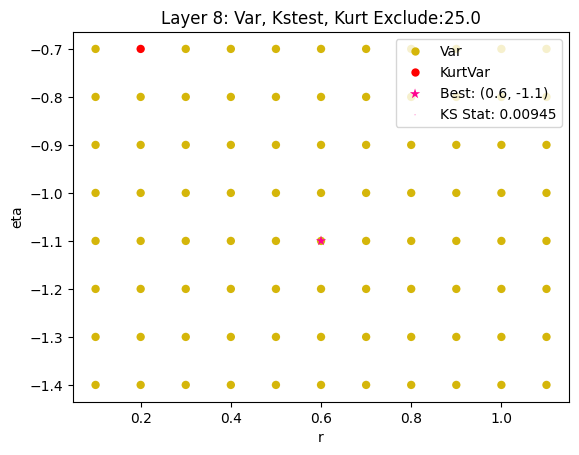

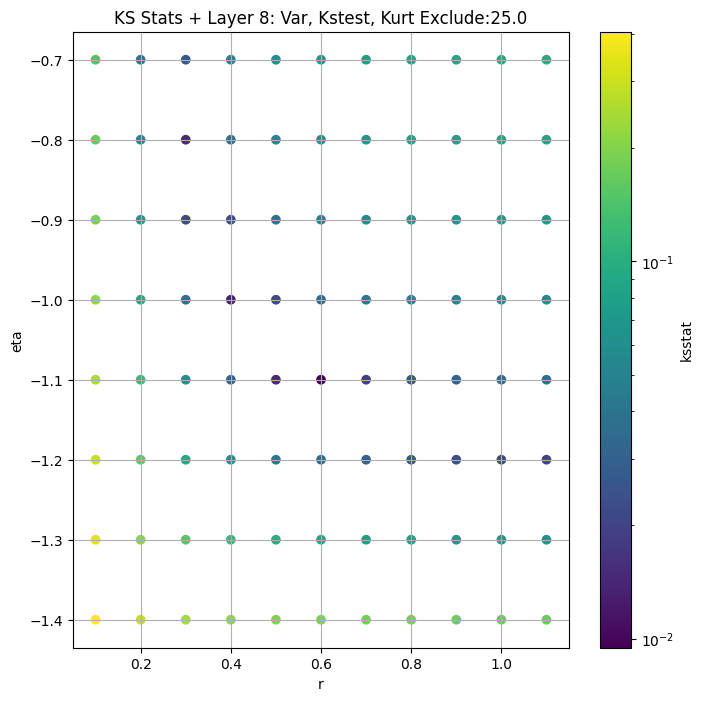

####
Layer  9


100%|██████████| 12760/12760 [00:37<00:00, 339.59it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.007686898956372312 78.41065


100%|██████████| 12760/12760 [00:35<00:00, 357.73it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.008432351515627767 75.08945


100%|██████████| 12760/12760 [00:38<00:00, 334.85it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.008892430292755993 73.14139


100%|██████████| 12760/12760 [00:37<00:00, 340.56it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.008708439757498021 71.45011


100%|██████████| 12760/12760 [00:35<00:00, 354.80it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.008911444367357801 69.92297


100%|██████████| 12760/12760 [00:35<00:00, 354.50it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.009535705684286966 67.21121


100%|██████████| 12760/12760 [00:36<00:00, 351.18it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.010139976835400133 64.830925


100%|██████████| 12760/12760 [00:36<00:00, 352.96it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.010718013115790681 62.696312


100%|██████████| 12760/12760 [00:36<00:00, 348.93it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.011267940371409213 60.756565


100%|██████████| 12760/12760 [00:35<00:00, 355.73it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.011848143613885136 58.97709


100%|██████████| 12760/12760 [00:34<00:00, 365.78it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.013101840442401202 54.377712
Number of samples: 100000, Without approximation : 295085108.0


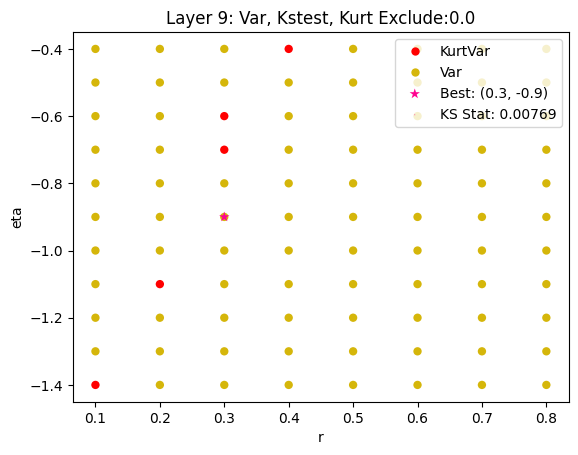

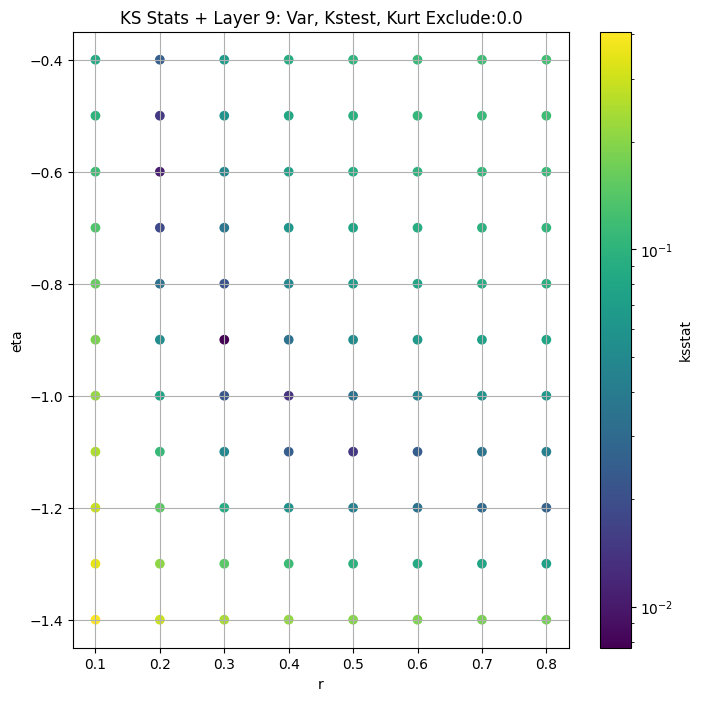

obs_var      var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                     
2      141841.72000       0.000000  209572.11000  -1.771987         NaN   
3      736460.30000  720182.060000  752624.20000  -1.273356   -1.336073   
4      465219.00000  445174.600000  485257.53000   0.832306    0.714066   
5      108838.26600  102539.490000  115350.62500   3.238030    2.715251   
6       47219.99000   43794.440000   50741.45700   6.126480    5.564133   
7        9147.18800    8511.764000    9801.52700   5.519940    5.009598   
8         918.93930     848.773740     993.63250   7.176670    5.902757   
9          78.41065      70.487915      87.48717  15.212063   10.426363   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.265918        4.3         20.0   
3       -1.193367        20050.0             0.088740        1.3         20.0   
4        0.962902       180942.0             0.013893        0.2         19.0   
5        3.809224       922650.0             0.004231        0.9         -0.5   
6        6.721452      4185552.0             0.008056        0.7         -0.9   
7        6.143659     17688454.0             0.009162        0.7         -1.1   
8       11.482376     72685058.0             0.009454        0.6         -1.1   
9       33.707012    295085108.0             0.007687        0.3         -0.9   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       99341.823024                     0.0        141841.72000   
3       85538.822255                     0.0        736460.30000   
4           0.000036                   250.0        445176.75000   
5       89902.441185                    50.0        105890.08600   
6       38413.804141                   350.0         40187.28000   
7       13890.370965                    50.0          8912.19000   
8        1021.718236                    25.0           898.36926   
9           1.953967                     0.0            78.41065   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.623939  
3                     0.009583  
4                     0.003192  
5                     0.001414  
6                     0.000664  
7                     0.000323  
8                     0.000159  
9                     0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 9/9 [00:00<00:00, 8278.23it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 4249.07it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 3205.02it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 7928.74it/s]


Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


100%|██████████| 9/9 [00:00<00:00, 10925.83it/s]

Finding Minimum after computing 9 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.2659183720558835, var: 141841.71875
Number of samples: 4, Without approximation : 4.0


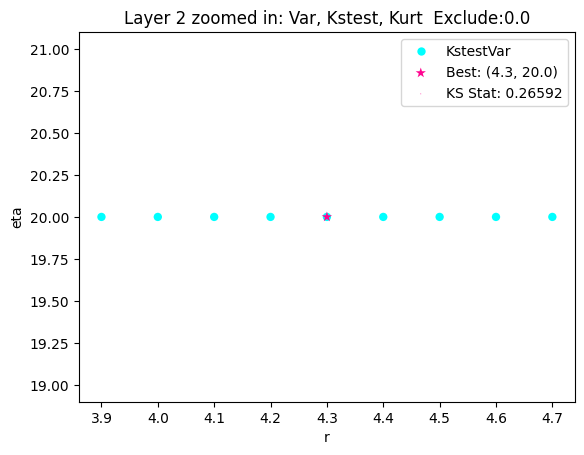

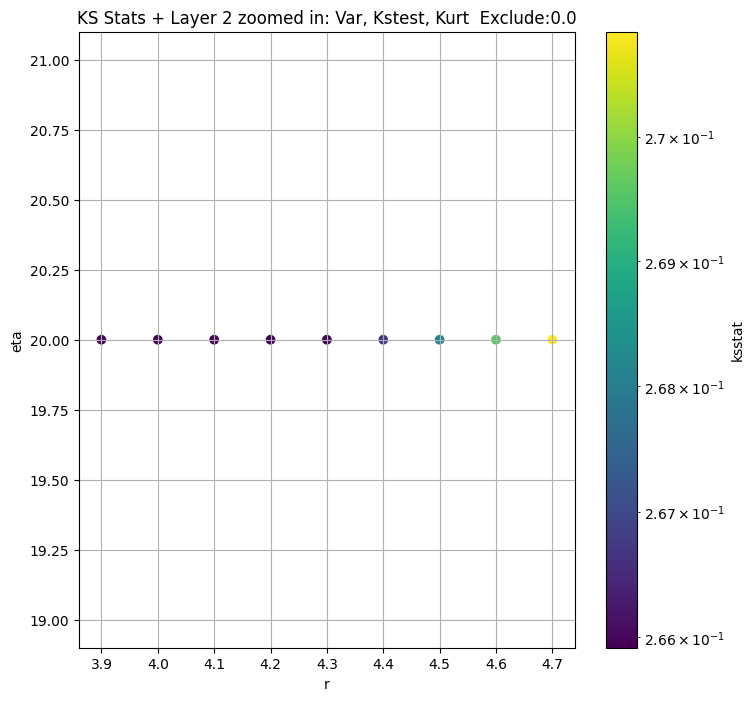

Layer 3


100%|██████████| 99/99 [00:00<00:00, 958.99it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.09176206257074876, var: 712830.5


100%|██████████| 99/99 [00:00<00:00, 1714.50it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.09117954228162739, var: 717118.5


100%|██████████| 99/99 [00:00<00:00, 1686.19it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.09057210211930006, var: 721626.5625


100%|██████████| 99/99 [00:00<00:00, 1458.16it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.08991390552561235, var: 726554.0


100%|██████████| 99/99 [00:00<00:00, 1200.78it/s]


Finding Minimum after computing 99 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.08862405686945118, var: 736460.3125
Number of samples: 20050, Without approximation : 20050.0


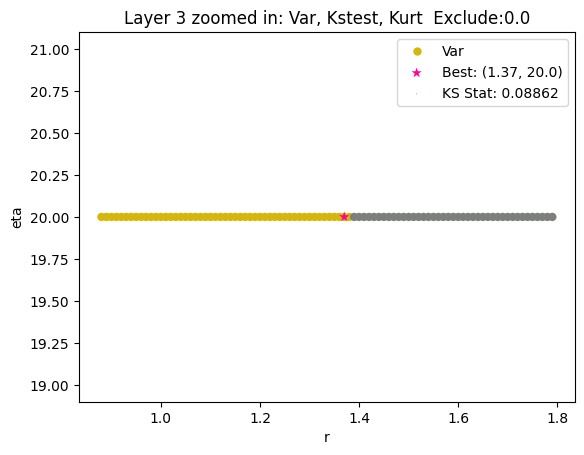

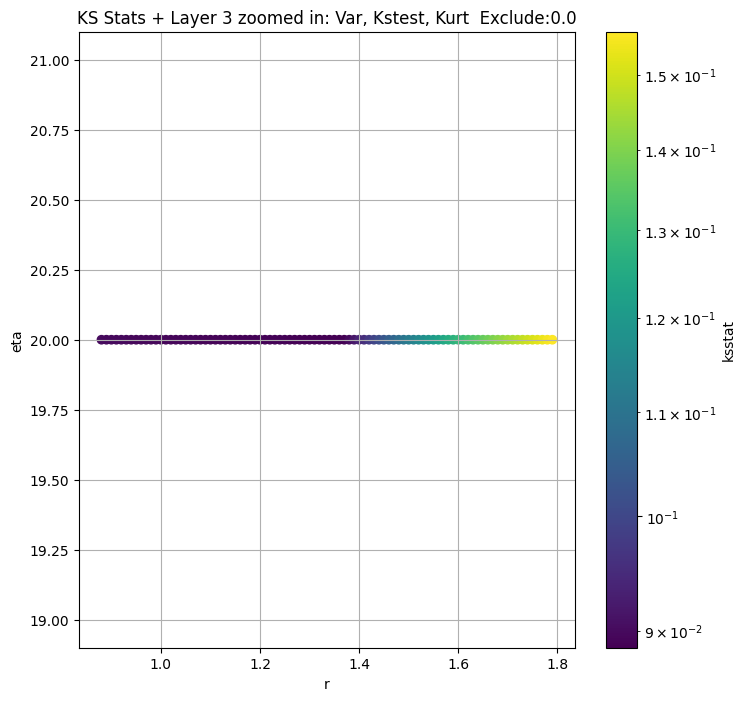

Layer 4


100%|██████████| 68/68 [00:00<00:00, 280.61it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 100 = 350, ksstat: 0.014538535617102877, var: 438106.0625


100%|██████████| 68/68 [00:00<00:00, 363.85it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 75 = 325, ksstat: 0.014384224000543476, var: 439849.96875


100%|██████████| 68/68 [00:00<00:00, 364.09it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 50 = 300, ksstat: 0.014229071398868868, var: 441608.75


100%|██████████| 68/68 [00:00<00:00, 363.94it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 25 = 275, ksstat: 0.01407271797368572, var: 443383.0


100%|██████████| 68/68 [00:00<00:00, 364.14it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + 0 = 250, ksstat: 0.013892614480876864, var: 445176.75


100%|██████████| 68/68 [00:00<00:00, 363.67it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -25 = 225, ksstat: 0.0141783419815813, var: 446988.15625


100%|██████████| 68/68 [00:00<00:00, 360.39it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -50 = 200, ksstat: 0.014271362235822593, var: 448816.375


100%|██████████| 68/68 [00:00<00:00, 359.44it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -75 = 175, ksstat: 0.014291097740143144, var: 450668.71875


100%|██████████| 68/68 [00:00<00:00, 347.94it/s]


Finding Minimum after computing 68 CDFs
layer 4, 250.0 + -100 = 150, ksstat: 0.014664329179683966, var: 452553.8125
Number of samples: 100000, Without approximation : 180942.0


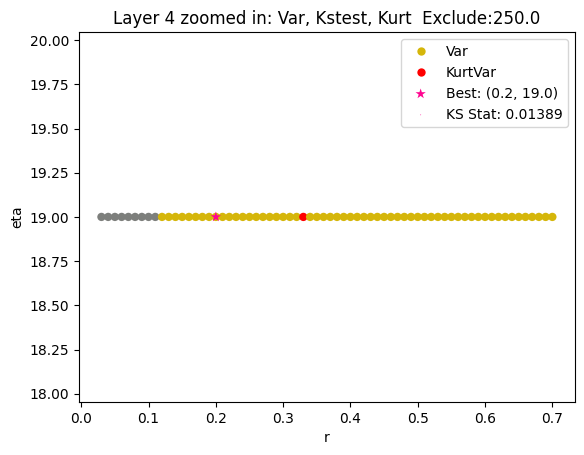

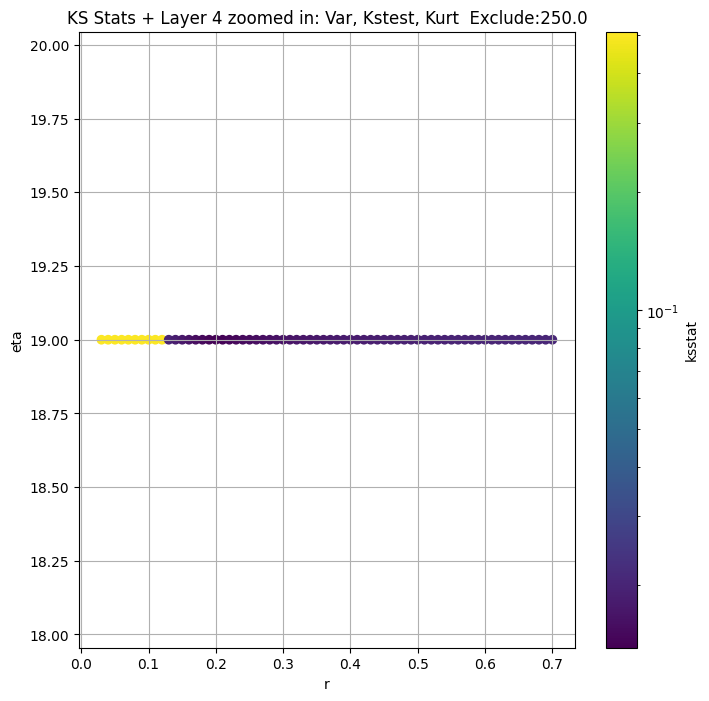

Layer 5


100%|██████████| 1800/1800 [00:05<00:00, 338.10it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.005457775086757821, var: 101562.828125


100%|██████████| 1800/1800 [00:04<00:00, 365.43it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.0051131602044206526, var: 102543.953125


100%|██████████| 1800/1800 [00:04<00:00, 365.31it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.0047650887585148904, var: 103582.484375


100%|██████████| 1800/1800 [00:04<00:00, 366.28it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.004393644608392422, var: 104694.109375


100%|██████████| 1800/1800 [00:04<00:00, 363.79it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.003976085826159603, var: 105890.0859375


100%|██████████| 1800/1800 [00:04<00:00, 363.85it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0038283905279234975, var: 107210.1328125


100%|██████████| 1800/1800 [00:04<00:00, 364.77it/s]


Finding Minimum after computing 1800 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.0038995166636811573, var: 108838.265625
Number of samples: 100000, Without approximation : 922650.0


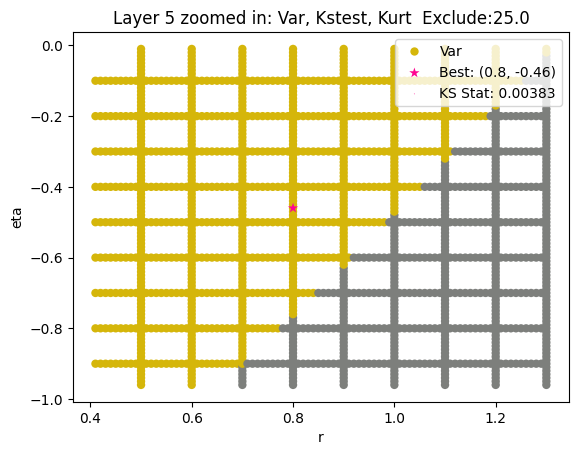

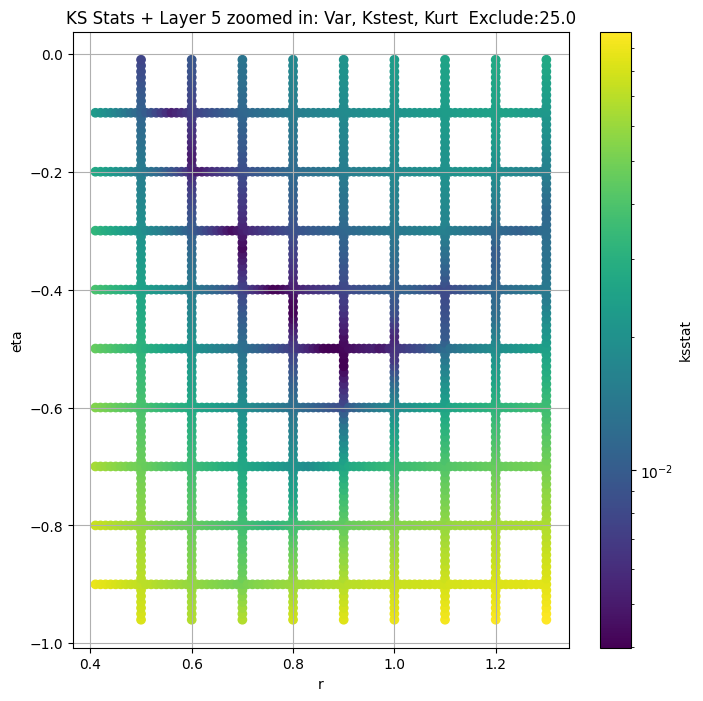

Layer 6


100%|██████████| 1900/1900 [00:05<00:00, 344.26it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 100 = 450, ksstat: 0.00884398963596333, var: 38626.45703125


100%|██████████| 1900/1900 [00:05<00:00, 359.76it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 75 = 425, ksstat: 0.008636781847346064, var: 39005.44921875


100%|██████████| 1900/1900 [00:05<00:00, 365.11it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 50 = 400, ksstat: 0.008409624470078883, var: 39391.640625


100%|██████████| 1900/1900 [00:05<00:00, 365.05it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 25 = 375, ksstat: 0.008213899370010047, var: 39785.36328125


100%|██████████| 1900/1900 [00:05<00:00, 365.86it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + 0 = 350, ksstat: 0.008026599390357084, var: 40187.28125


100%|██████████| 1900/1900 [00:05<00:00, 363.21it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -25 = 325, ksstat: 0.007791125153641776, var: 40597.34375


100%|██████████| 1900/1900 [00:05<00:00, 364.68it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -50 = 300, ksstat: 0.007610510801709719, var: 41016.1875


100%|██████████| 1900/1900 [00:05<00:00, 364.95it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -75 = 275, ksstat: 0.00738339755847456, var: 41444.265625


100%|██████████| 1900/1900 [00:05<00:00, 365.92it/s]


Finding Minimum after computing 1900 CDFs
layer 6, 350.0 + -100 = 250, ksstat: 0.007402573184783462, var: 41882.50390625
Number of samples: 100000, Without approximation : 4185552.0


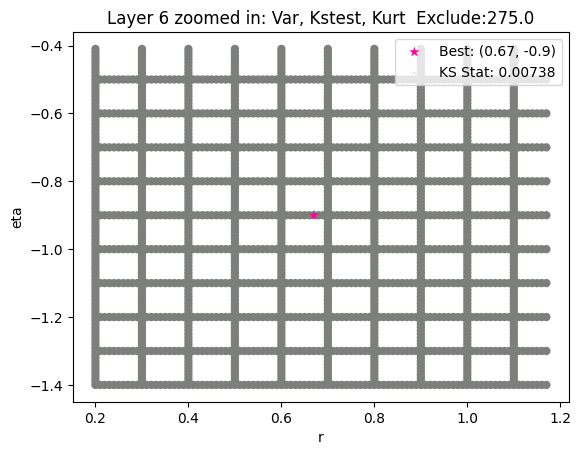

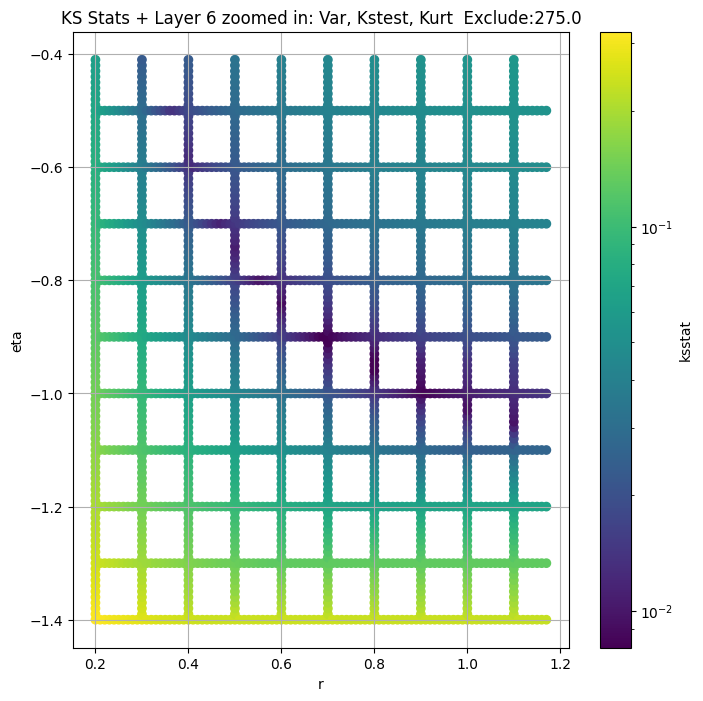

Layer 7


100%|██████████| 1570/1570 [00:04<00:00, 362.98it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 100 = 150, ksstat: 0.009854427439139446, var: 8545.3125


100%|██████████| 1570/1570 [00:04<00:00, 362.39it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 75 = 125, ksstat: 0.00970808865756495, var: 8631.3046875


100%|██████████| 1570/1570 [00:04<00:00, 364.48it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 50 = 100, ksstat: 0.00945984355824427, var: 8720.5068359375


100%|██████████| 1570/1570 [00:04<00:00, 364.58it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 25 = 75, ksstat: 0.009204412405512341, var: 8813.7099609375


100%|██████████| 1570/1570 [00:04<00:00, 364.55it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + 0 = 50, ksstat: 0.009021137169361482, var: 8912.1904296875


100%|██████████| 1570/1570 [00:04<00:00, 365.09it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -25 = 25, ksstat: 0.008740028957439763, var: 9018.61328125


100%|██████████| 1570/1570 [00:04<00:00, 360.06it/s]


Finding Minimum after computing 1570 CDFs
layer 7, 50.0 + -50 = 0, ksstat: 0.008913438385160247, var: 9147.1884765625
Number of samples: 100000, Without approximation : 17688454.0


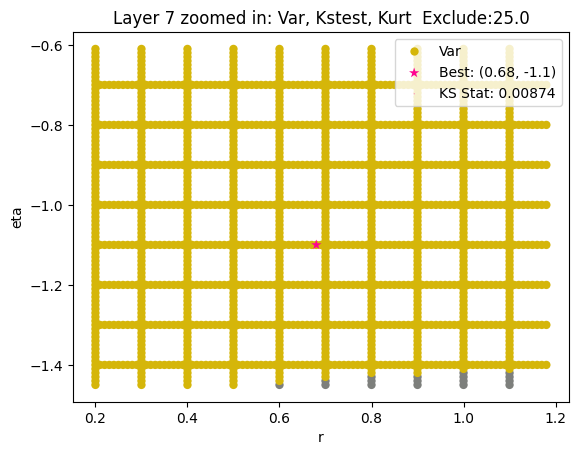

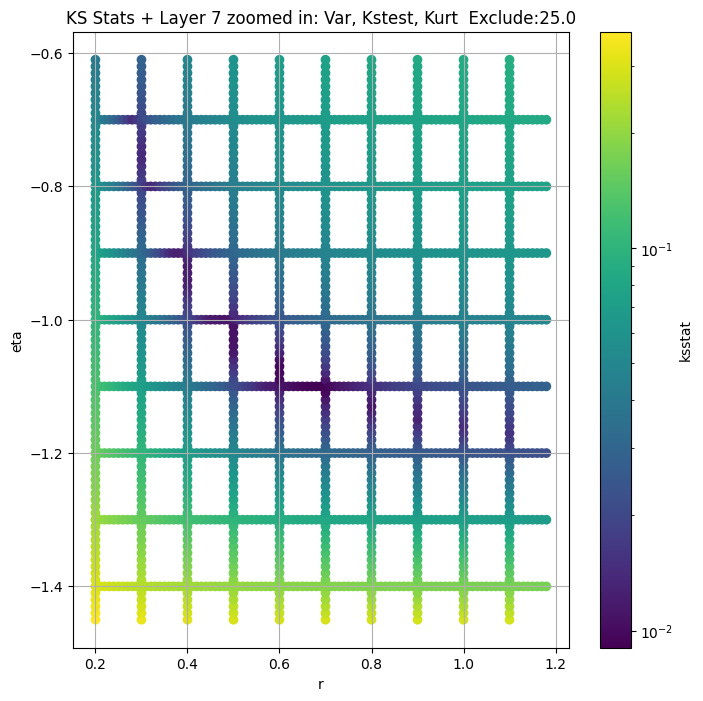

Layer 8


100%|██████████| 1485/1485 [00:04<00:00, 363.01it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.010297029941300273, var: 849.7969970703125


100%|██████████| 1485/1485 [00:04<00:00, 359.84it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.010369148848429655, var: 860.623779296875


100%|██████████| 1485/1485 [00:04<00:00, 352.97it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.010086123354904886, var: 872.1280517578125


100%|██████████| 1485/1485 [00:04<00:00, 365.61it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.0097832310390559, var: 884.5311889648438


100%|██████████| 1485/1485 [00:04<00:00, 359.57it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.009441071089726076, var: 898.3692626953125


100%|██████████| 1485/1485 [00:04<00:00, 364.82it/s]


Finding Minimum after computing 1485 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.009382636849035009, var: 918.9392700195312
Number of samples: 100000, Without approximation : 72685058.0


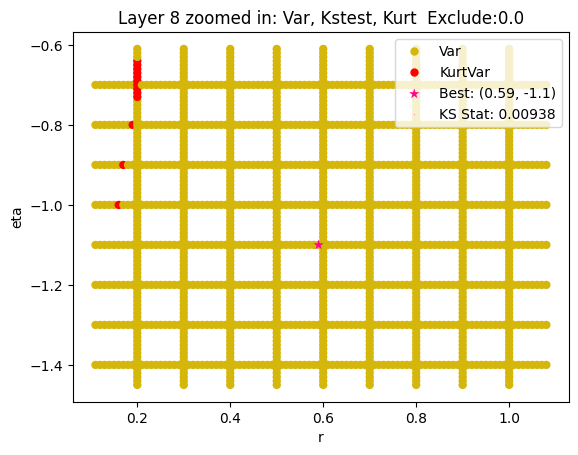

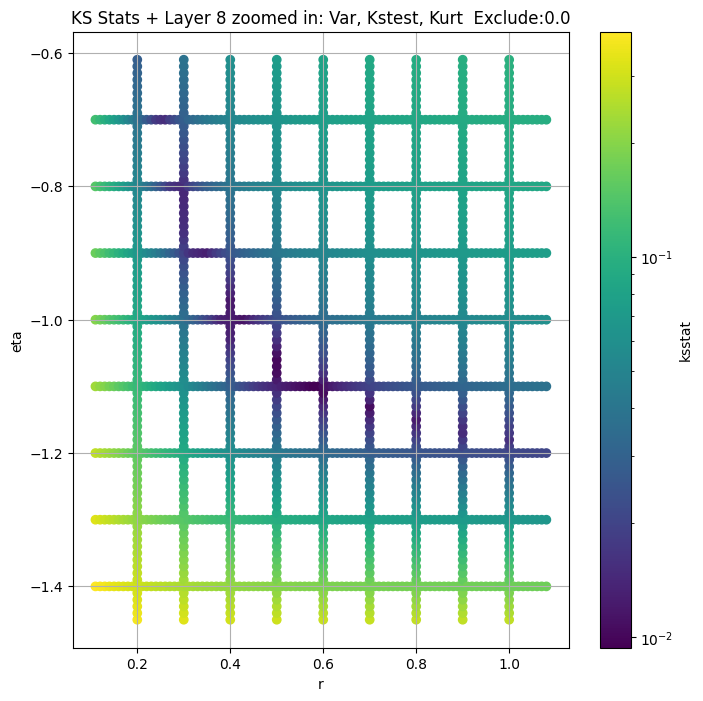

Layer 9


100%|██████████| 1410/1410 [00:03<00:00, 361.85it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.007877233256322502, var: 69.9229736328125


100%|██████████| 1410/1410 [00:03<00:00, 362.16it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.007555681498764004, var: 71.45011138916016


100%|██████████| 1410/1410 [00:03<00:00, 364.52it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.006993798244344651, var: 73.14138793945312


100%|██████████| 1410/1410 [00:03<00:00, 365.78it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.0067305476483564, var: 75.08944702148438


100%|██████████| 1410/1410 [00:03<00:00, 361.82it/s]


Finding Minimum after computing 1410 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.0066367744587900734, var: 78.41065216064453
Number of samples: 100000, Without approximation : 295085108.0


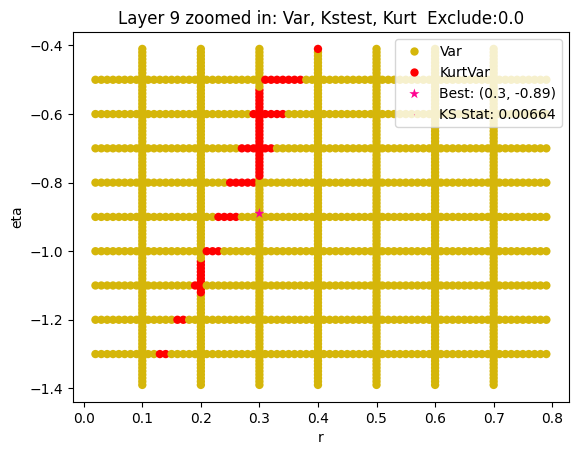

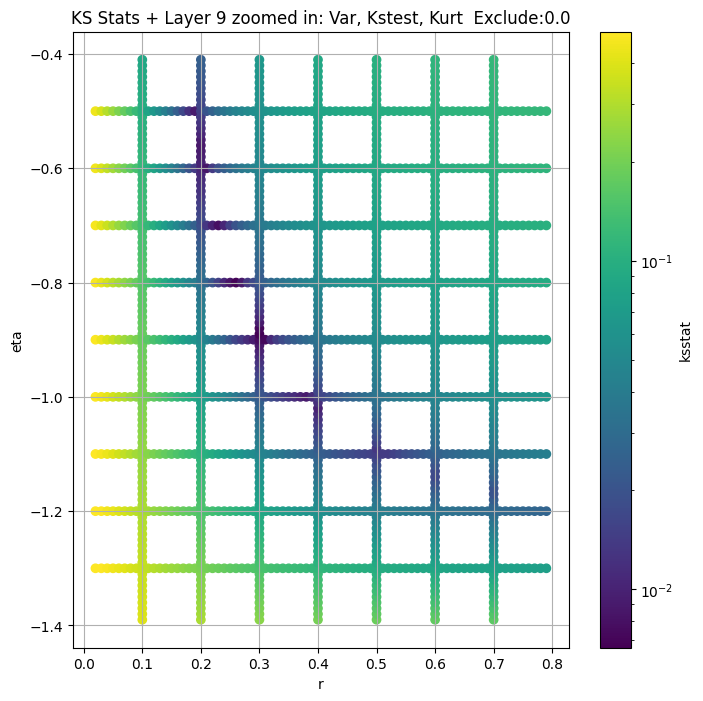

obs_var      var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                     
2      141841.72000       0.000000  209572.11000  -1.771987         NaN   
3      736460.30000  720182.060000  752624.20000  -1.273356   -1.336073   
4      465219.00000  445174.600000  485257.53000   0.832306    0.714066   
5      108838.26600  102539.490000  115350.62500   3.238030    2.715251   
6       47219.99000   43794.440000   50741.45700   6.126480    5.564133   
7        9147.18800    8511.764000    9801.52700   5.519940    5.009598   
8         918.93930     848.773740     993.63250   7.176670    5.902757   
9          78.41065      70.487915      87.48717  15.212063   10.426363   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.265918        4.3         20.0   
3       -1.193367        20050.0             0.088740        1.3         20.0   
4        0.962902       180942.0             0.013893        0.2         19.0   
5        3.809224       922650.0             0.004231        0.9         -0.5   
6        6.721452      4185552.0             0.008056        0.7         -0.9   
7        6.143659     17688454.0             0.009162        0.7         -1.1   
8       11.482376     72685058.0             0.009454        0.6         -1.1   
9       33.707012    295085108.0             0.007687        0.3         -0.9   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       99341.823024                     0.0       141841.720000   
3       85538.822255                     0.0       736460.312500   
4           0.000036                   250.0       445176.750000   
5       89902.441185                    50.0       107210.132812   
6       38413.804141                   350.0        41444.265625   
7       13890.370965                    50.0         9018.613281   
8        1021.718236                    25.0          918.939270   
9           1.953967                     0.0           78.410652   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.623939          0.265918    4.30     20.00   
3                     0.009583          0.088624    1.37     20.00   
4                     0.003192          0.013893    0.20     19.00   
5                     0.001414          0.003828    0.80     -0.46   
6                     0.000664          0.007383    0.67     -0.90   
7                     0.000323          0.008740    0.68     -1.10   
8                     0.000159          0.009383    0.59     -1.10   
9                     0.000079          0.006637    0.30     -0.89   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      99341.823024                  0.0           24  
3      99329.120756                  0.0          234  
4          0.000036                250.0         9540  
5      69837.224568                 25.0       129747  
6      36054.261710                275.0        32699  
7      13328.861945                 25.0        24591  
8       1004.580200                  0.0        19962  
9          1.880653                  0.0        40522

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

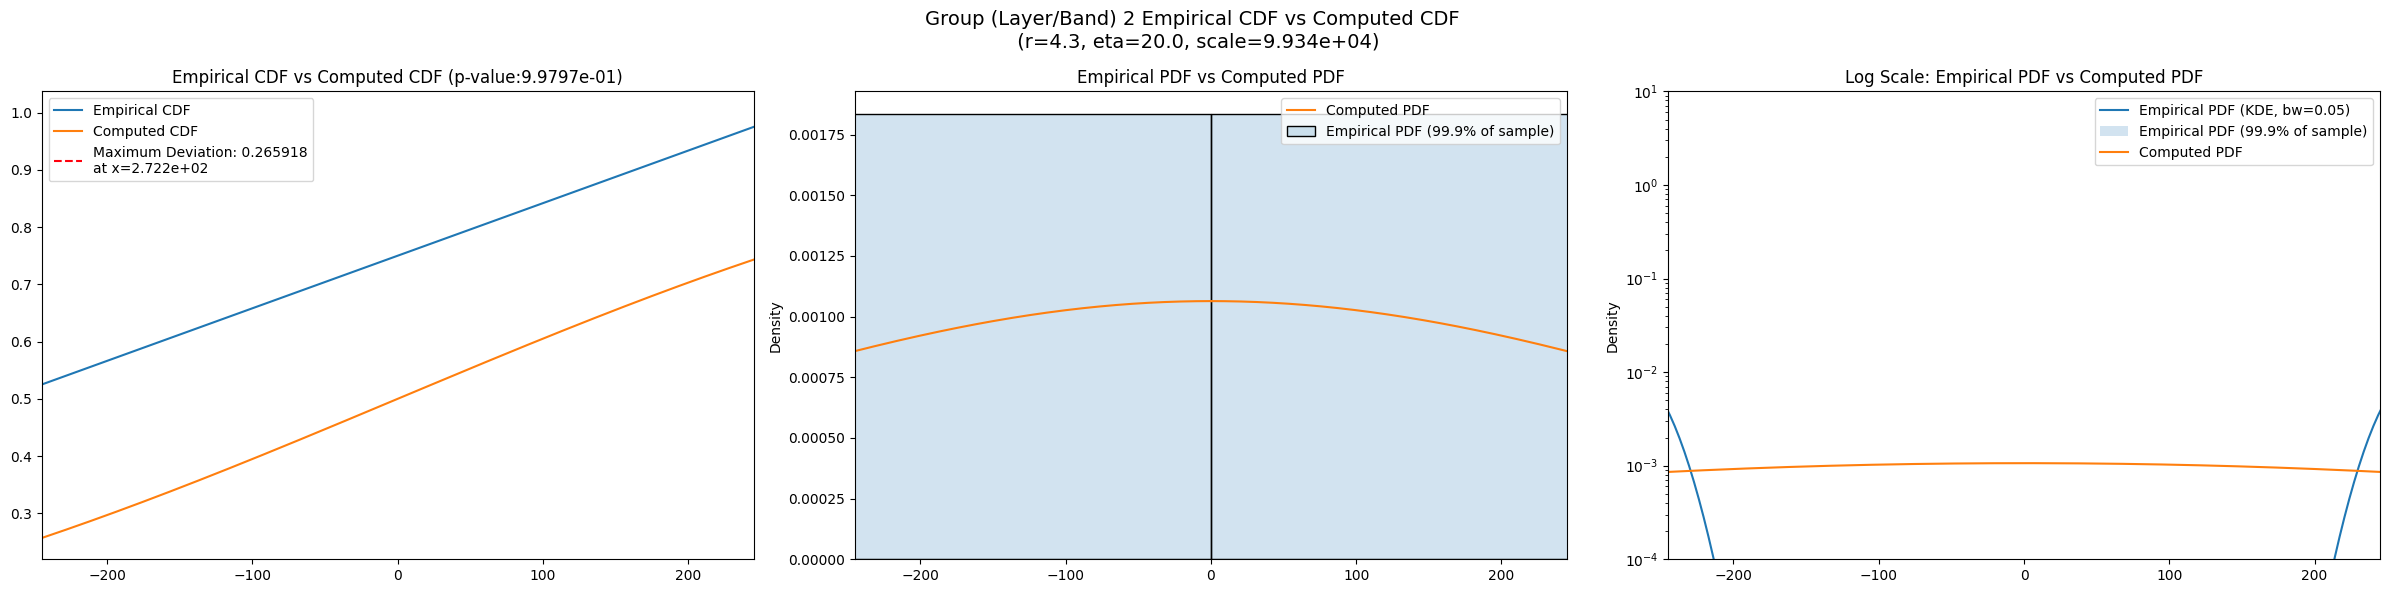

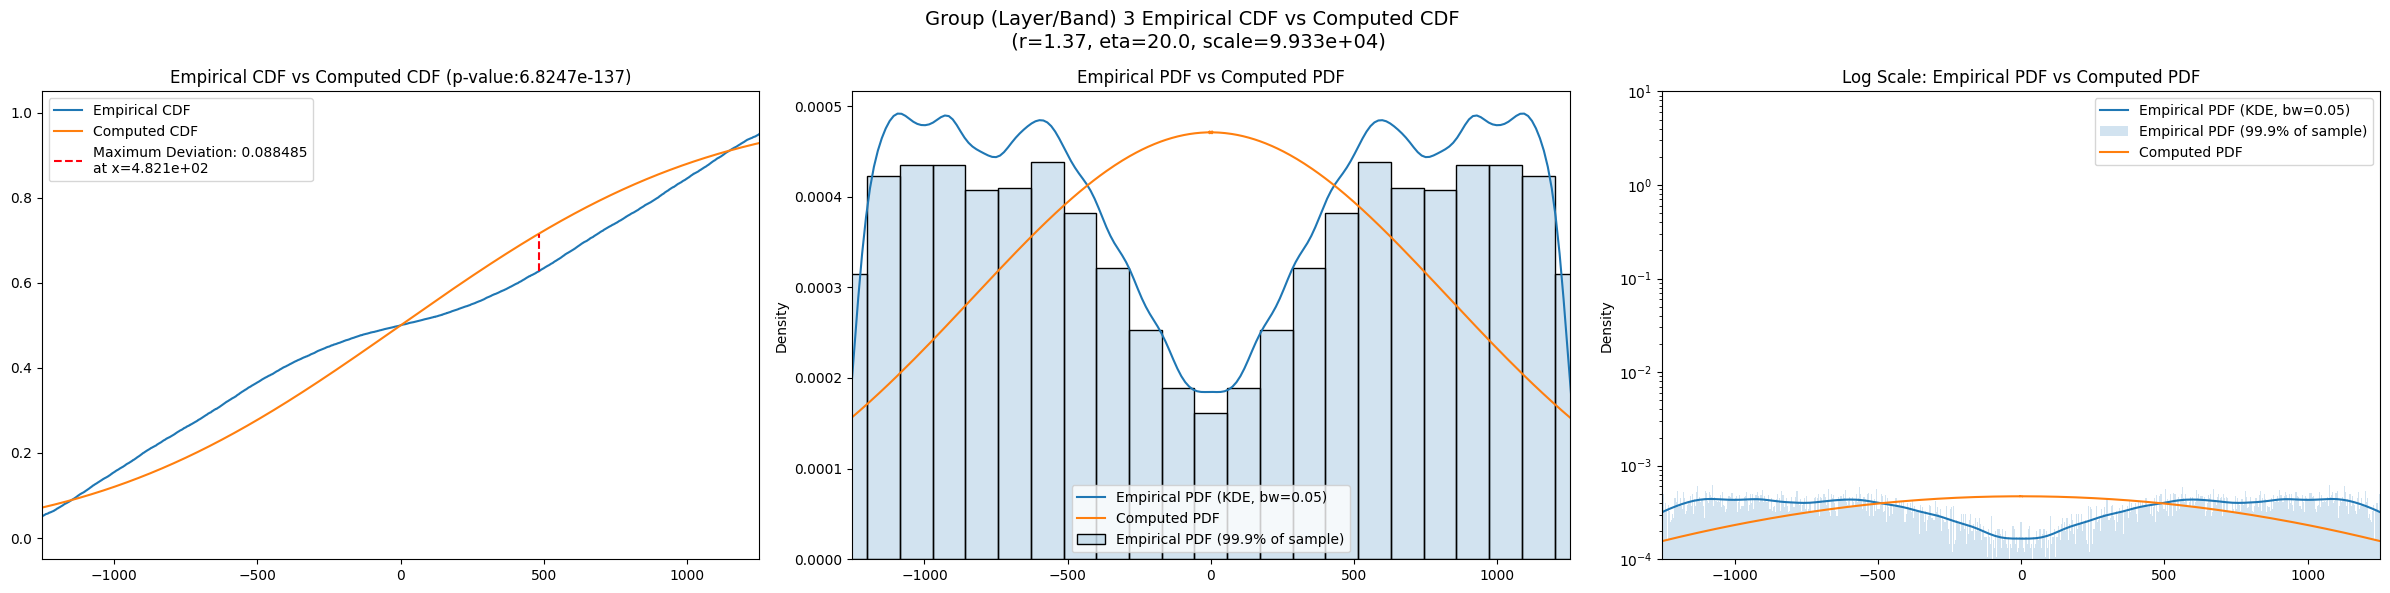

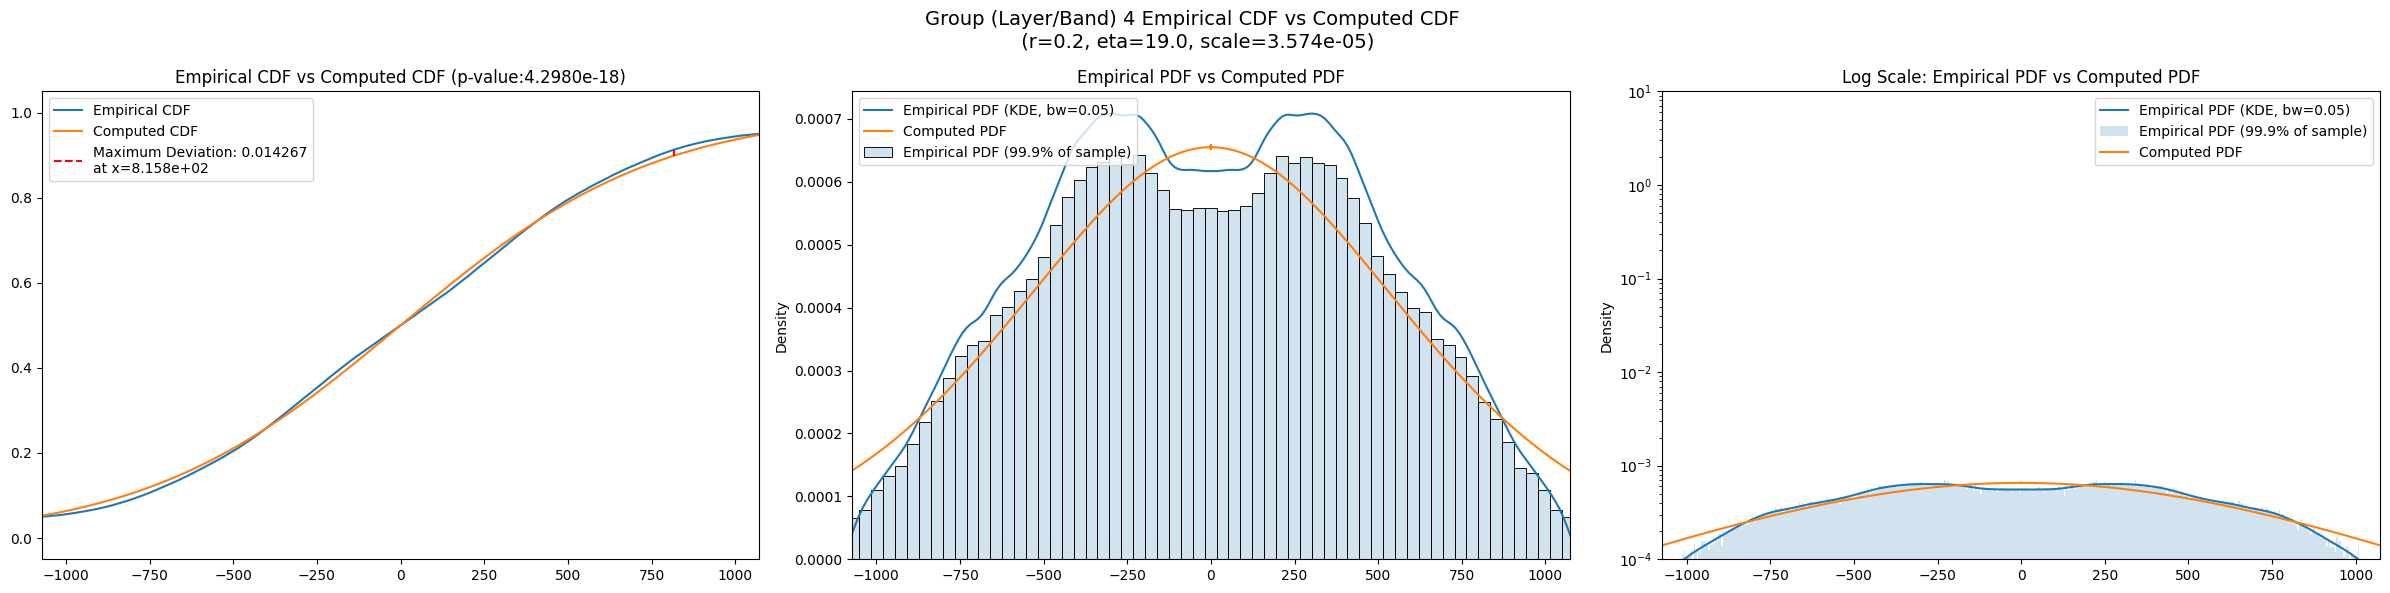

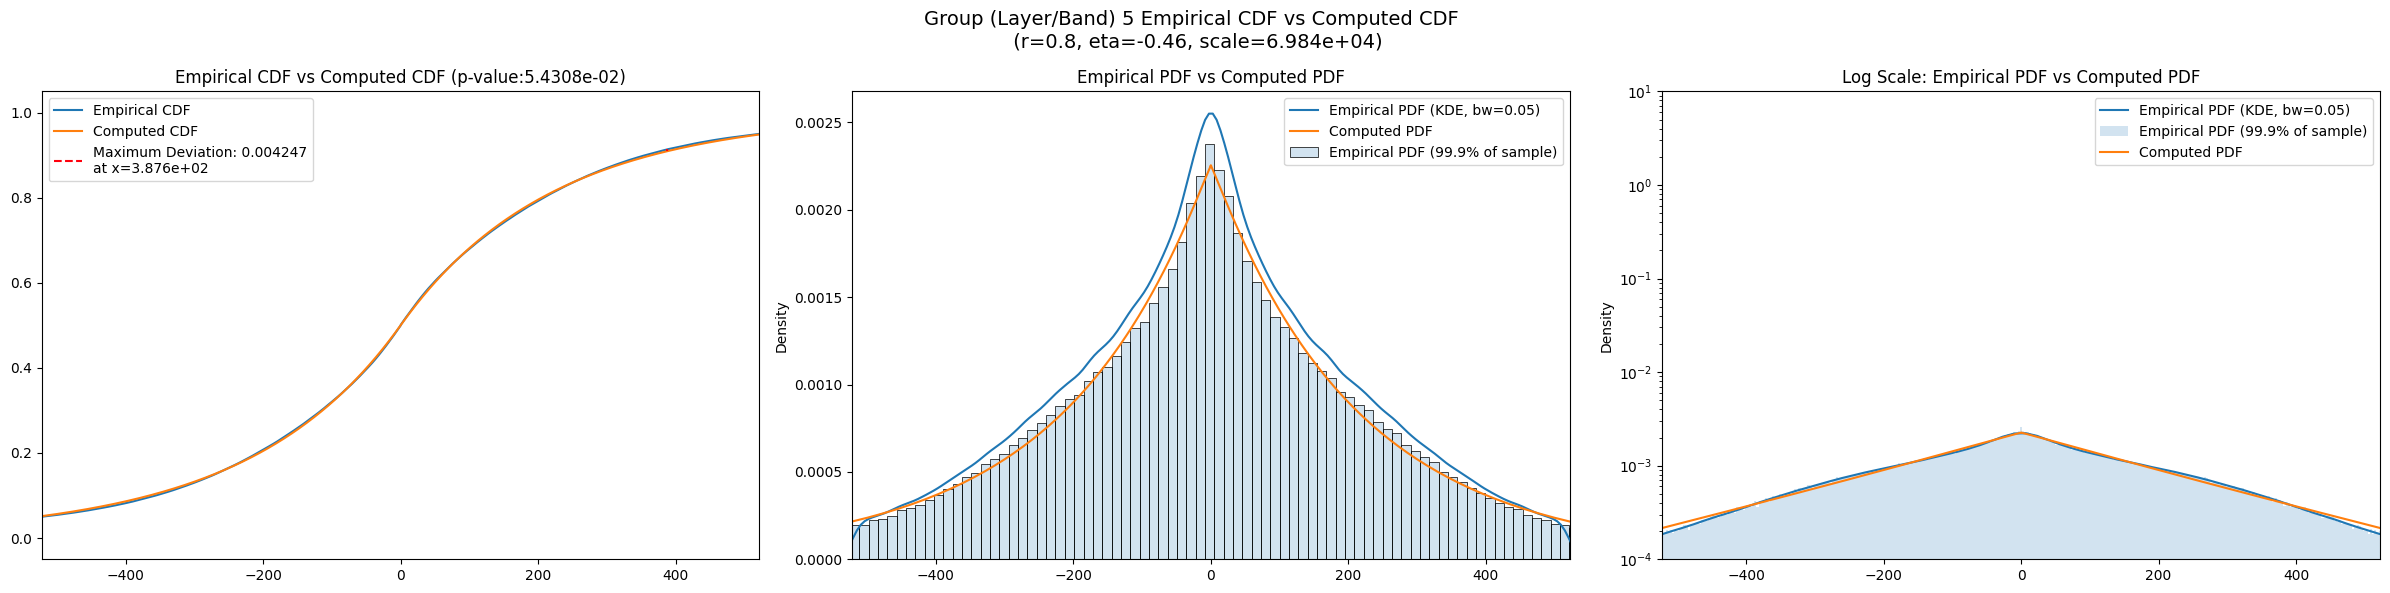

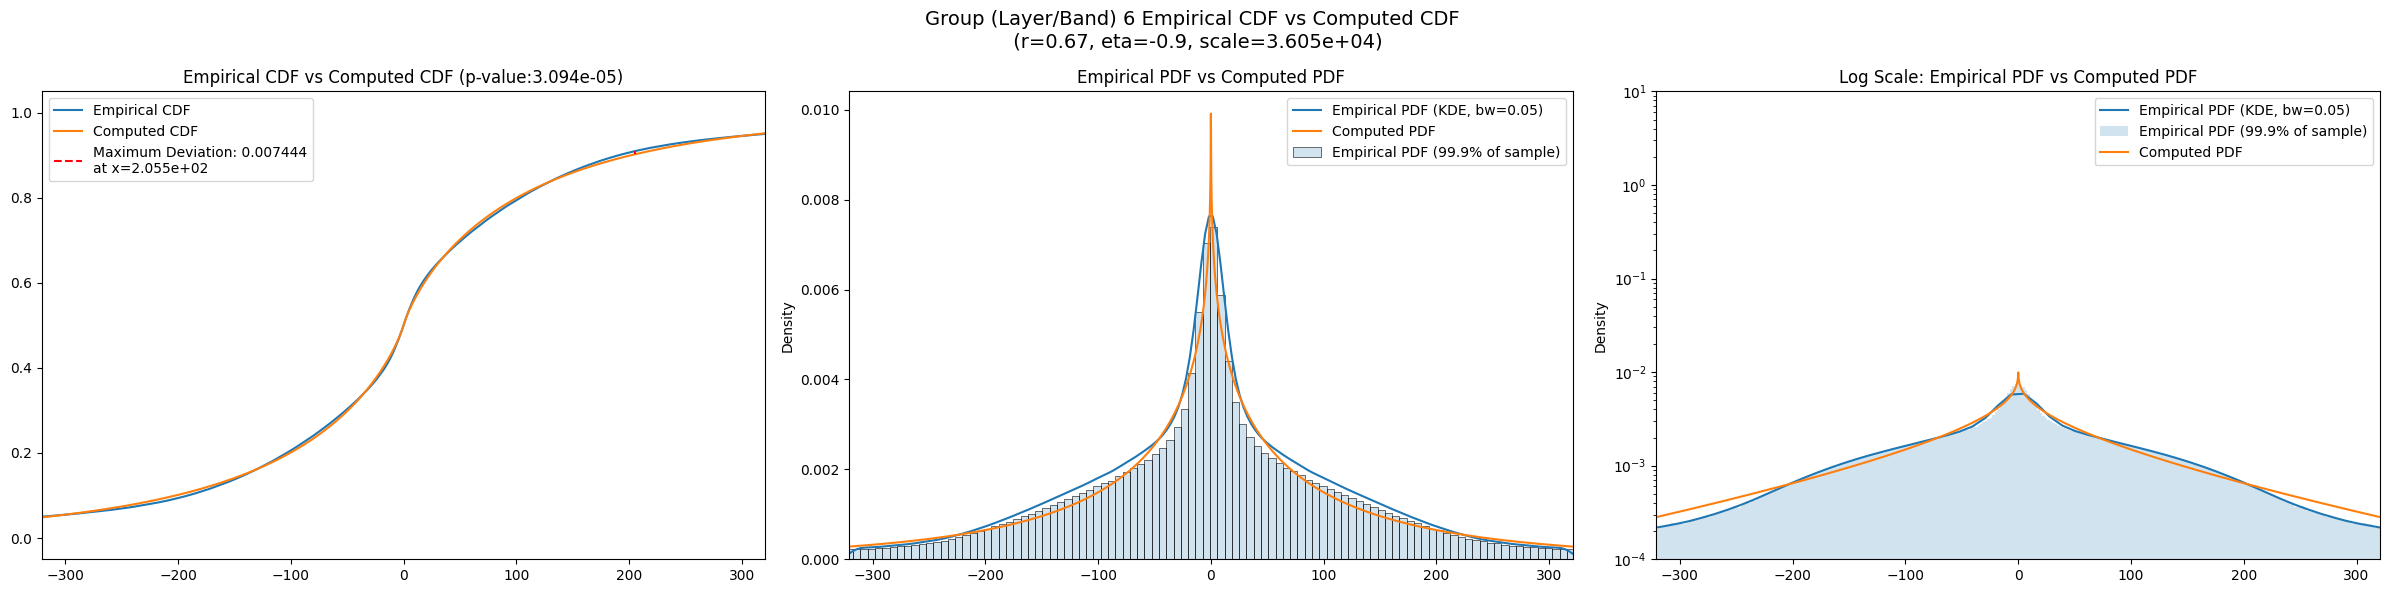

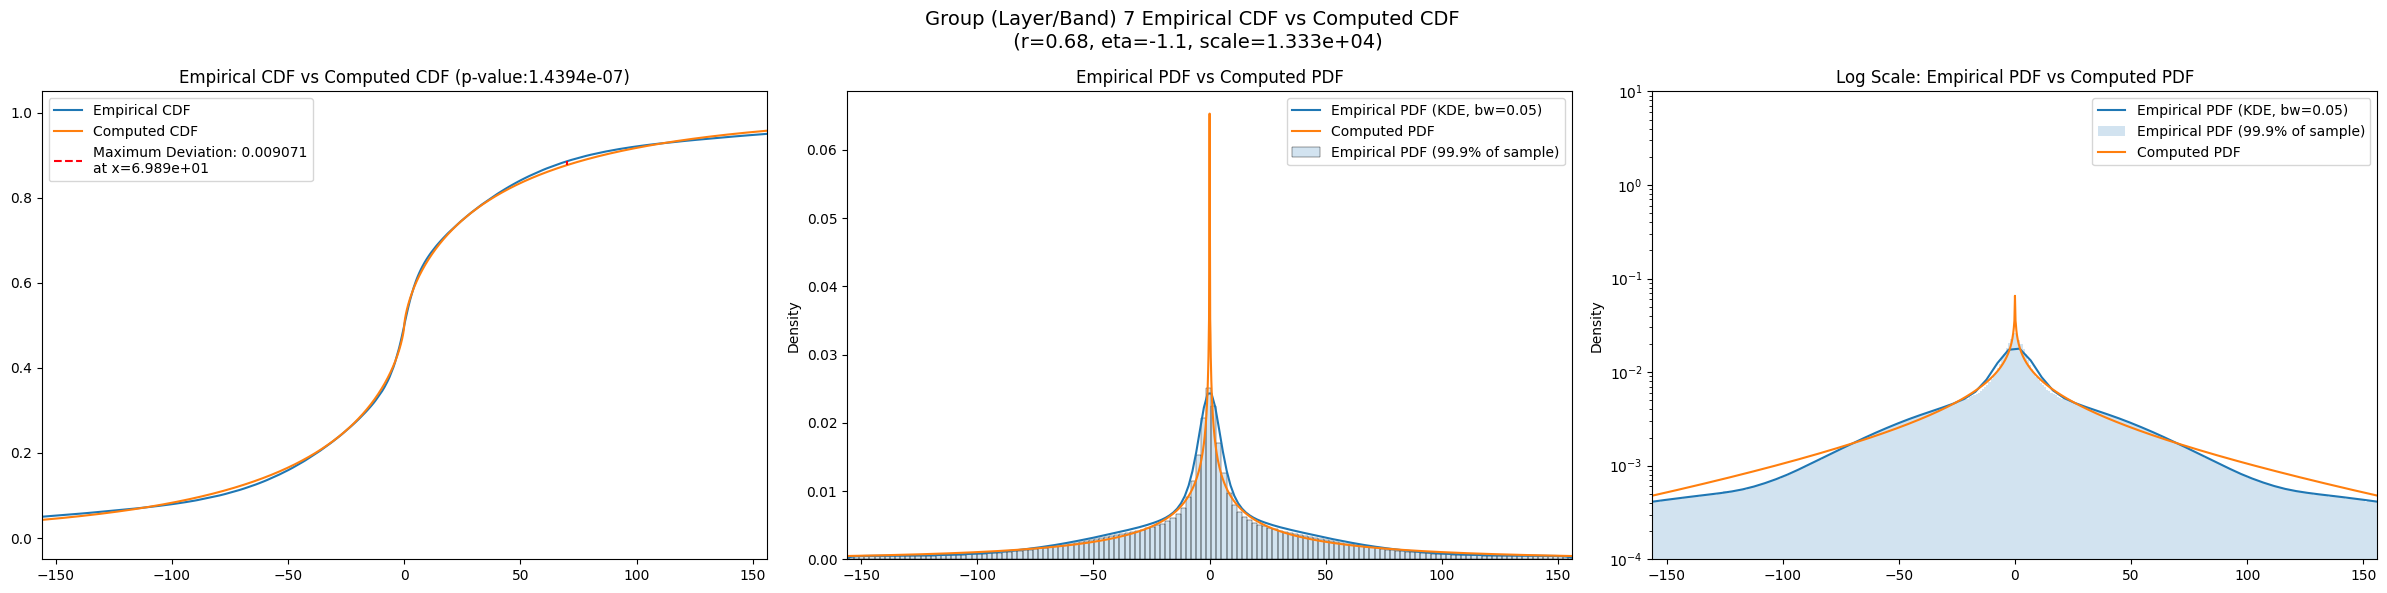

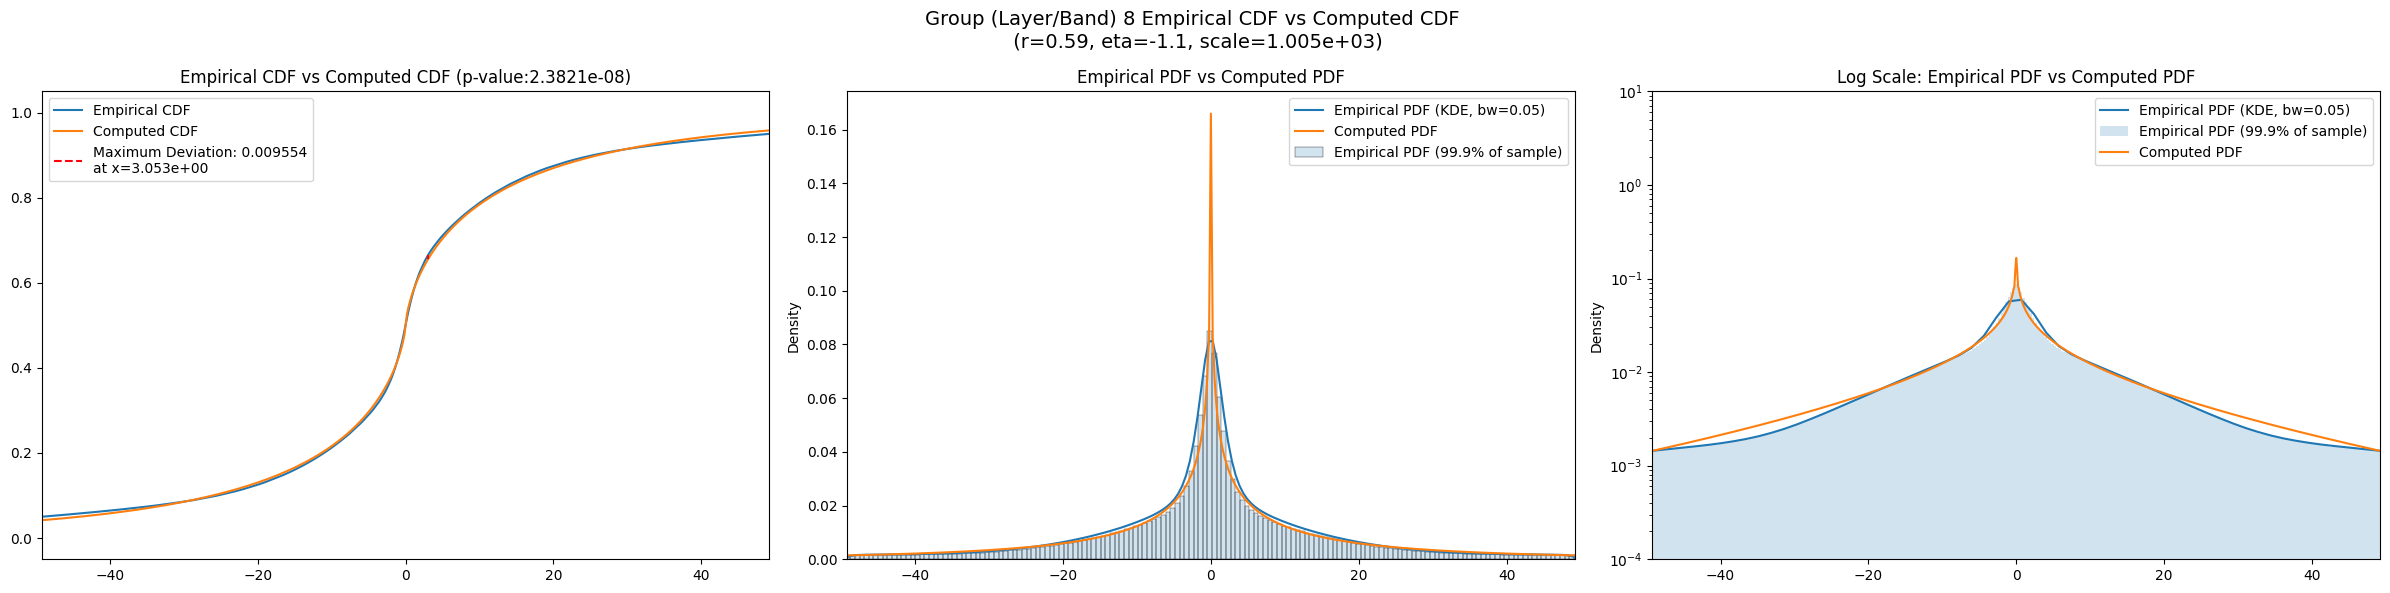

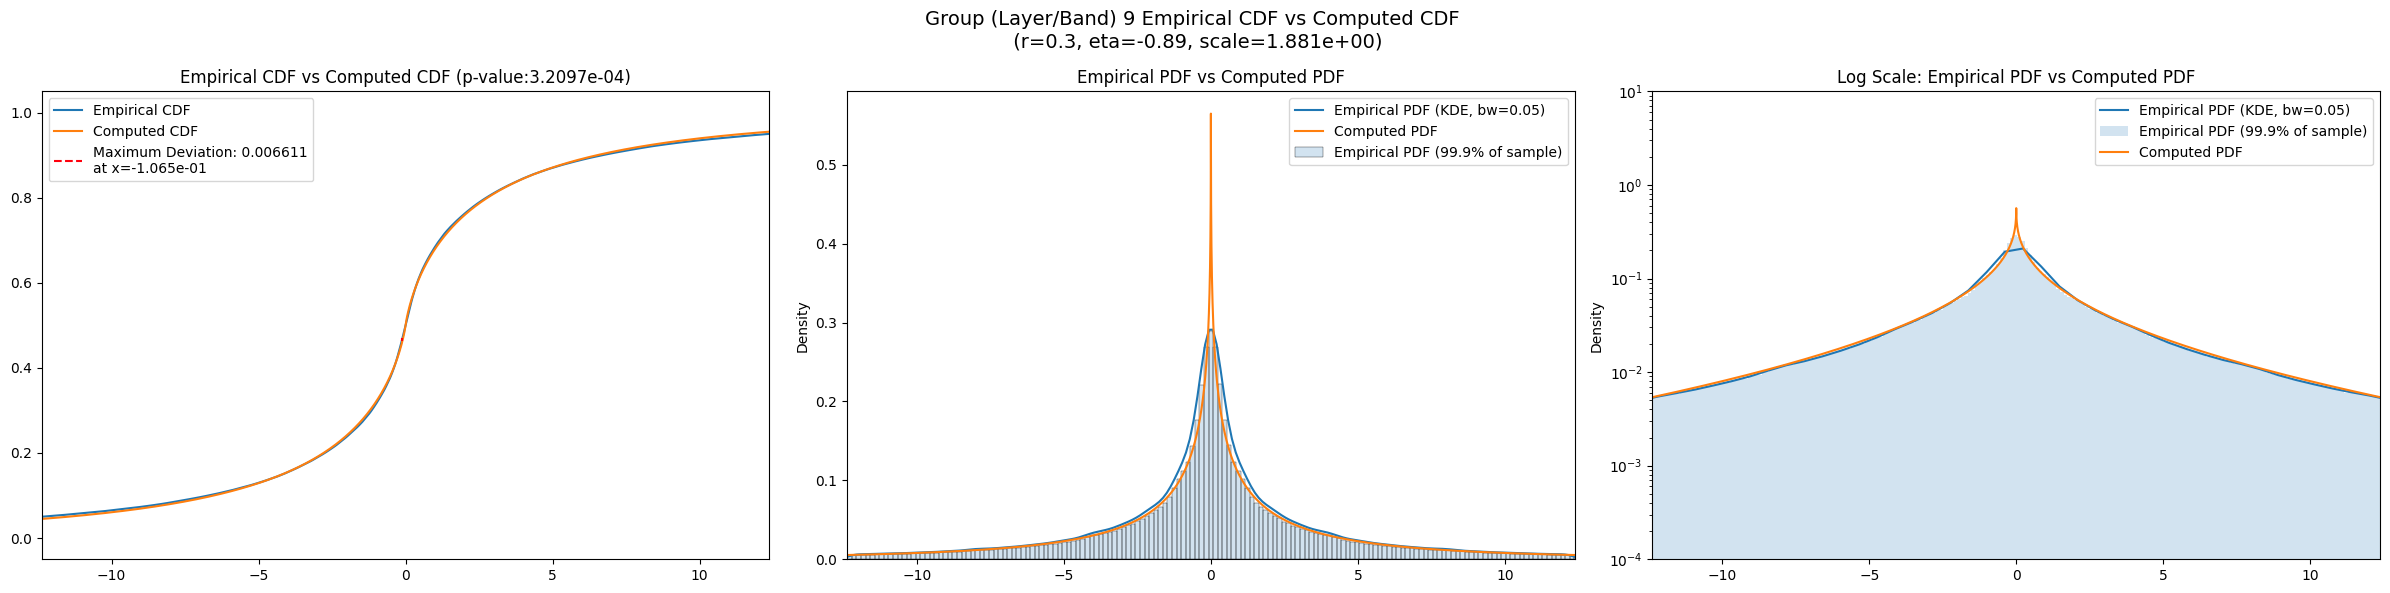

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                     
2      141841.72000       0.000000  209572.11000  -1.771987         NaN   
3      736460.30000  720182.060000  752624.20000  -1.273356   -1.336073   
4      465219.00000  445174.600000  485257.53000   0.832306    0.714066   
5      108838.26600  102539.490000  115350.62500   3.238030    2.715251   
6       47219.99000   43794.440000   50741.45700   6.126480    5.564133   
7        9147.18800    8511.764000    9801.52700   5.519940    5.009598   
8         918.93930     848.773740     993.63250   7.176670    5.902757   
9          78.41065      70.487915      87.48717  15.212063   10.426363   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            4.0             0.265918        4.3         20.0   
3       -1.193367        20050.0             0.088740        1.3         20.0   
4        0.962902       180942.0             0.013893        0.2         19.0   
5        3.809224       922650.0             0.004231        0.9         -0.5   
6        6.721452      4185552.0             0.008056        0.7         -0.9   
7        6.143659     17688454.0             0.009162        0.7         -1.1   
8       11.482376     72685058.0             0.009454        0.6         -1.1   
9       33.707012    295085108.0             0.007687        0.3         -0.9   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       533.05200              0.195222          9.906630e-01   
3      ...       987.74400              0.061776          5.836750e-67   
4      ...       653.30300              0.018661          3.645030e-55   
5      ...       257.47400              0.029410          0.000000e+00   
6      ...       122.59300              0.049473          0.000000e+00   
7      ...        43.95150              0.068660          0.000000e+00   
8      ...        13.28390              0.074117          0.000000e+00   
9      ...         3.54259              0.072795          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          514.60000             0.205409         9.839470e-01  436.00400   
3          884.19400             0.086364        1.468700e-130  738.03700   
4          570.81600             0.033409        6.736920e-176  473.59300   
5          227.40000             0.005047         7.691640e-21  186.00500   
6          105.12400             0.026863         0.000000e+00   84.22810   
7           38.24210             0.045826         0.000000e+00   29.28370   
8           11.54900             0.050151         0.000000e+00    8.83745   
9            3.07733             0.046889         0.000000e+00    2.38568   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.201946   9.865390e-01          8.678729e-01  
3           0.083629  1.944790e-122         1.795330e-137  
4           0.029025  7.311000e-133          9.168615e-31  
5           0.010529   2.833590e-89          3.581416e-12  
6           0.030873   0.000000e+00         1.287917e-198  
7           0.046043   0.000000e+00          0.000000e+00  
8           0.049777   0.000000e+00          0.000000e+00  
9           0.047191   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.265918                 0.623939          0.265918   
3                 0.088740                 0.009583          0.088624   
4                 0.013893                 0.003192          0.013893   
5                 0.004231                 0.001414          0.003828   
6                 0.008056                 0.000664          0.007383   
7                 0.009162                 0.000323          0.008740   
8                 0.009454                 0.000159          0.009383   
9                 0.007687                 0.000079          0.006637   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.195222             0.205409       0.201946  
3                  0.061776             0.086364       0.083629  
4                  0.018661             0.033409       0.029025  
5                  0.029410             0.005047       0.010529  
6                  0.049473             0.026863       0.030873  
7                  0.068660             0.045826       0.046043  
8                  0.074117             0.050151       0.049777  
9                  0.072795             0.046889       0.047191

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2           141841.720000          0.265918    4.30     20.00  99341.823024   
3           736460.312500          0.088624    1.37     20.00  99329.120756   
4           445176.750000          0.013893    0.20     19.00      0.000036   
5           107210.132812          0.003828    0.80     -0.46  69837.224568   
6            41444.265625          0.007383    0.67     -0.90  36054.261710   
7             9018.613281          0.008740    0.68     -1.10  13328.861945   
8              918.939270          0.009383    0.59     -1.10   1004.580200   
9               78.410652          0.006637    0.30     -0.89      1.880653   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                    250.0  
5                     25.0  
6                    275.0  
7                     25.0  
8                      0.0  
9                      0.0

In [21]:
eng.quit()